In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
# Read in dataframe
df = pd.read_csv('teleco_time_series .csv')

In [3]:
# Check for duplicates
print(df['Day'].duplicated().sum())

0


In [4]:
# Set Day as the index
df = df.set_index('Day')

# Initial Exploration of Dataset

In [5]:
# First five rows of dataset
df.head()

,Revenue
Day,
1,0.000000
2,0.000793
3,0.825542
4,0.320332
5,1.082554


In [6]:
# Check for null values and review data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 731 entries, 1 to 731
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  731 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


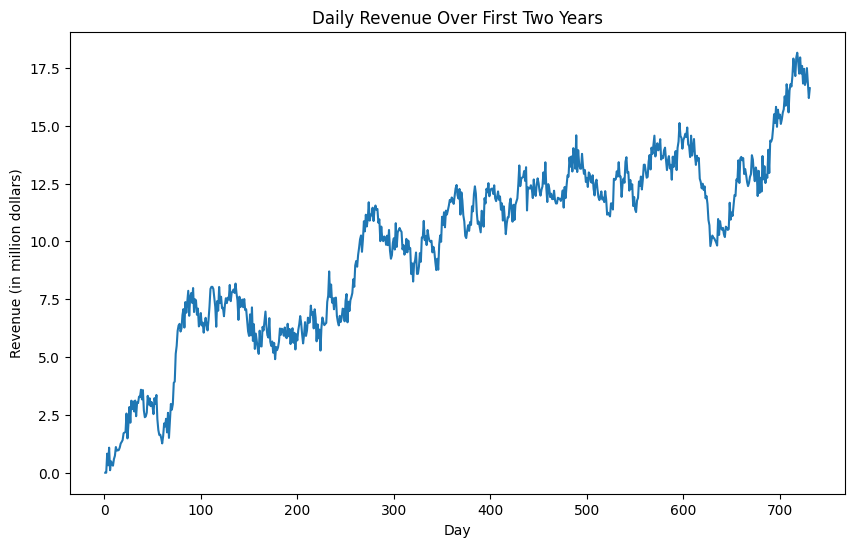

In [7]:
# Create line plot realizing time series
df['Revenue'].plot(figsize=(10,6))
plt.xlabel('Day')
plt.ylabel('Revenue (in million dollars)')
plt.title('Daily Revenue Over First Two Years')
plt.show()

# Check Time Series Integrety

In [8]:
# Create a series containing the range 1 to 731
expected_days = pd.Series(range(1, 732))

# Reduce expected_days to those that do not exist in original Day column
missing_days = expected_days[~expected_days.isin(df.index)]

# Print resulting missing days
print(missing_days)

Series([], dtype: int64)


# Check Stationarity

In [9]:
# Run ADFULLER to evaluate the stationarity of the time series (Reider, n.d.d)
result = adfuller(df['Revenue'], autolag = 'AIC')

# Print the results
print(f'Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

Test Statistic: -1.9246121573101809
p-value: 0.32057281507939783
Critical Values:
1%: -3.4393520240470554
5%: -2.8655128165959236
10%: -2.5688855736949163


In [10]:
# Apply differencing
diff_df = df.diff()

# Drop null values produced by differencing
diff_df = diff_df.dropna()

# Confirm there are no null values
print(diff_df['Revenue'].isnull().sum())

0


In [11]:
# Run ADFULLER to re-evaluate the stationarity of the time series (Reider, n.d.d)
result = adfuller(diff_df['Revenue'], autolag = 'AIC')

print(f'Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

Test Statistic: -44.874527193875984
p-value: 0.0
Critical Values:
1%: -3.4393520240470554
5%: -2.8655128165959236
10%: -2.5688855736949163


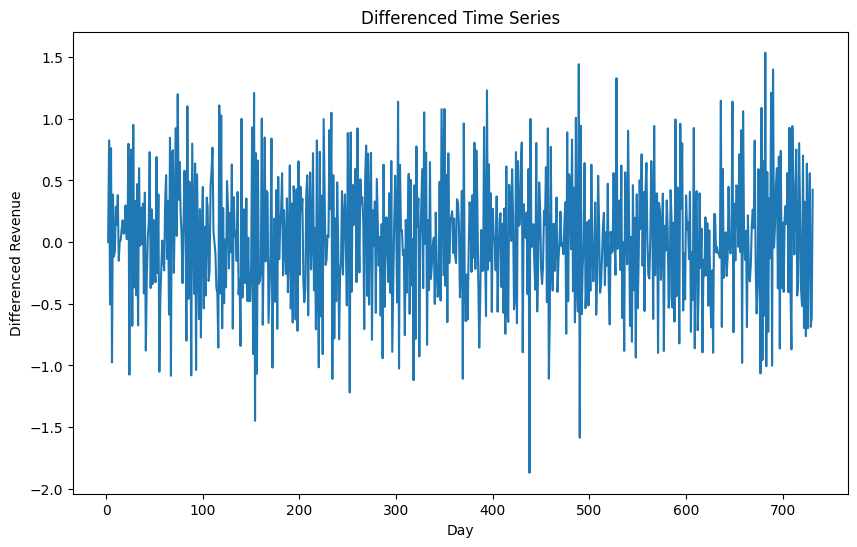

In [12]:
# Plot the differenced data to visually inspect stationarity
plt.figure(figsize=(10,6))
plt.plot(diff_df)
plt.title('Differenced Time Series')
plt.xlabel('Day')
plt.ylabel('Differenced Revenue')
plt.show()

# Split Data into Training and Test Sets

In [13]:
# Print original shape
print(f'Original shape: {df.shape}')

# Determine split point using 80/20 (80% for Training, 20% for Test)
split_ratio = 0.8
split_point = int(len(df) * split_ratio)
print(f'Split point is {split_point}')

# Split the data using the split point and iloc (Sewell, 2024a)
train = df.iloc[:split_point]
test = df.iloc[split_point:]

# Verify shapes
print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')


Original shape: (731, 1)
Split point is 584
Train shape: (584, 1)
Test shape: (147, 1)


In [14]:
train.to_csv('train.csv')
test.to_csv('test.csv')

# Reviewing Decomposition and Spectral Density

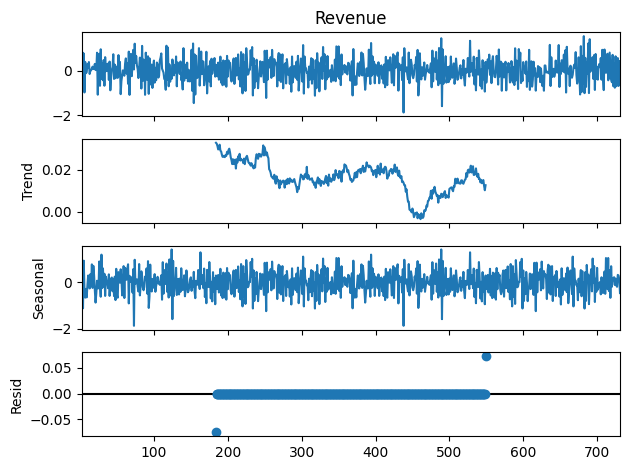

In [15]:
# Perform a seasonal decomposition (Sewell, 2024a)
result = seasonal_decompose(diff_df['Revenue'], model='additive', period=365)
result.plot()
plt.show()

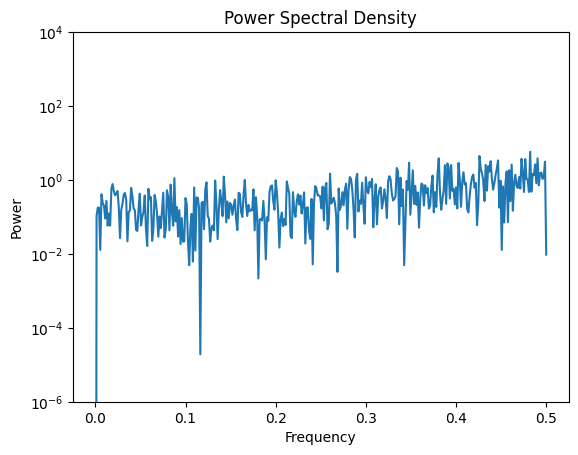

In [16]:
# Perform periodogram to capture the frequencies and power of the dataset (SciPy, 2024)
frequencies, power = periodogram(diff_df['Revenue'])

# Plot the result
plt.semilogy(frequencies, power)
plt.ylim([1e-6, 1e4])
plt.title('Power Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

# Determine ARIMA Parameters

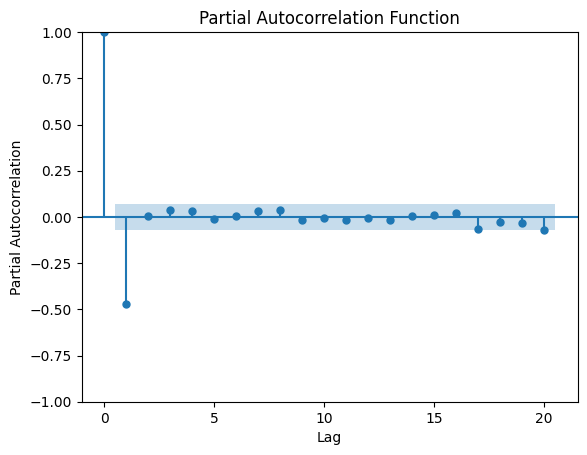

In [17]:
# Run Partial Autocorrelation Function to determine AR value (n.d.b)
plot_pacf(diff_df['Revenue'], lags=20)
plt.title('Partial Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

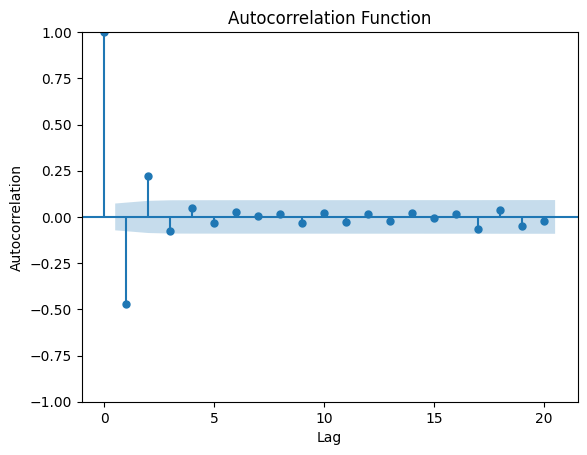

In [18]:
# Run Partial Autocorrelation Function to determine MA value (n.d.a)
plot_acf(diff_df['Revenue'], lags=20)
plt.title('Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Select ARIMA Model and Evaluate

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
# Define the ARIMA model using the AR and MA parameters (Reider, n.d.c)

# Try ARIMA model using 1,1,1 and print AIC
model_1 = ARIMA(df['Revenue'], order=(1,1,1))
model_1_fit = model_1.fit()
print(f'Model 1 with 1,1,1: {model_1_fit.aic}')

# Try ARIMA model using 1,1,1 and print AIC
model_2 = ARIMA(df['Revenue'], order=(1,1,0))
model_2_fit = model_2.fit()
print(f'Model 2 with 1,1,0: {model_2_fit.aic}')

# Try ARIMA model using 2,1,0 and print AIC
model_3 = ARIMA(df['Revenue'], order=(1,1,2))
model_3_fit = model_3.fit()
print(f'Model 3 with 1,1,2: {model_3_fit.aic}')

# Try ARIMA model using 2,1,0 and print AIC
model_4 = ARIMA(df['Revenue'], order=(2,1,0))
model_4_fit = model_3.fit()
print(f'Model 4 with 2,1,0: {model_4_fit.aic}')

Model 1 with 1,1,1: 986.6517104362356
Model 2 with 1,1,0: 984.7100557719148
Model 3 with 1,1,2: 986.8180892042813
Model 4 with 2,1,0: 986.8180892042813


In [21]:
# View summary of ARIMA model 1 (with order 1,1,1)
print(model_1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  731
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -490.326
Date:                Sat, 06 Jul 2024   AIC                            986.652
Time:                        16:55:47   BIC                           1000.431
Sample:                             0   HQIC                           991.968
                                - 731                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4804      0.068     -7.063      0.000      -0.614      -0.347
ma.L1          0.0176      0.077      0.227      0.821      -0.134       0.169
sigma2         0.2243      0.013     17.764      0.0

In [22]:
# View summary of ARIMA model 2 (with order 1,1,0)
print(model_2_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  731
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -490.355
Date:                Sat, 06 Jul 2024   AIC                            984.710
Time:                        16:55:47   BIC                            993.896
Sample:                             0   HQIC                           988.254
                                - 731                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4667      0.033    -14.213      0.000      -0.531      -0.402
sigma2         0.2243      0.013     17.782      0.000       0.200       0.249
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [23]:
# Because the first model had the lowest AIC score, that is the model we will use
# We now refit the model using our training data
model = ARIMA(train['Revenue'], order=(1,1,0))
model_fit = model.fit()

In [24]:
# Use model to predict on Training set to then compare against Test set (Sewell, 2024b) 
start = len(train)
end=len(train)+len(test)-1
pred = model_fit.predict(start=start, end=end, typ='levels')
print(pred)

584    13.311586
585    13.400077
586    13.359566
587    13.378112
588    13.369622
         ...    
726    13.372288
727    13.372288
728    13.372288
729    13.372288
730    13.372288
Name: predicted_mean, Length: 147, dtype: float64


In [25]:
# Produce RMSE
rmse = sqrt(mean_squared_error(pred, test['Revenue']))
print(f'RMSE: {rmse}')

RMSE: 2.1765066850059585


In [26]:
min_revenue = df['Revenue'].min()
max_revenue = df['Revenue'].max()

range_revenue = max_revenue - min_revenue
print(f'Revenue Range: {range_revenue}')

rmse_percentage = ((rmse / range_revenue) * 100).round(2)
print(f'RMSE as a Percentage of Range: {rmse_percentage}%')

Revenue Range: 18.15476909
RMSE as a Percentage of Range: 11.99%


# Predict Future Values

In [27]:
# Re-fit the model using the complete Revenue dataset
model = ARIMA(df['Revenue'], order=(1,1,0))
model_fit = model.fit()

# Forecast the predictions and predict off the mean (Elleh, 2024)
forecast=model_fit.get_forecast(steps=90)
future_pred = forecast.predicted_mean.rename('Forecast')

# Produce Confidence Interval (Elleh, 2024)
conf_int = forecast.conf_int()
print(future_pred)

731    16.422010
732    16.514776
733    16.471486
734    16.491688
735    16.482261
         ...    
816    16.485260
817    16.485260
818    16.485260
819    16.485260
820    16.485260
Name: Forecast, Length: 90, dtype: float64


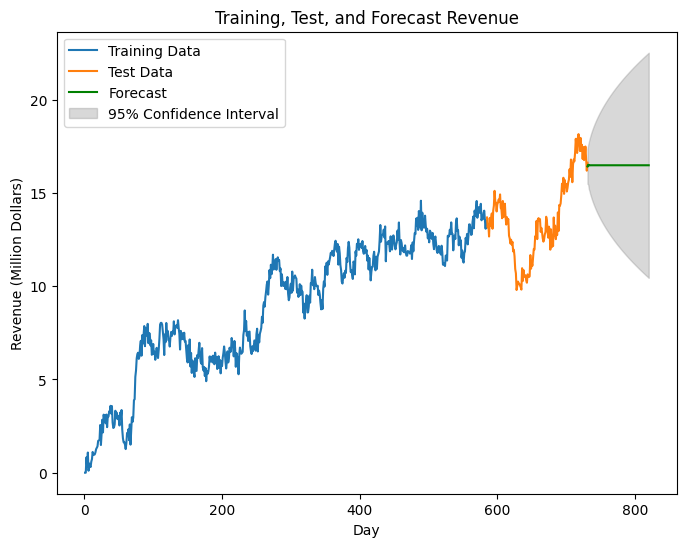

In [28]:
# Plot the Training, Test, and Forecast data together along with the Confidence Interval (Elleh, 2024)
plt.figure(figsize=(8,6))
plt.plot(train['Revenue'], label='Training Data')
plt.plot(test['Revenue'], label='Test Data')
plt.plot(future_pred, label='Forecast', color='green')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='grey', alpha=0.3, label='95% Confidence Interval')
plt.title('Training, Test, and Forecast Revenue')
plt.xlabel('Day')
plt.ylabel('Revenue (Million Dollars)')
plt.legend()
plt.show()